# Old Optimists, Young Pessimists

This example is based no Chapter 10 of *[Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions](https://greenteapress.com/wp/probably-overthinking-it)*, University of Chicago Press, 2023.

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [3]:
# download utils.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import decorate

# Set the random seed so we get the same results every time
np.random.seed(17)

<IPython.core.display.Javascript object>

In [5]:
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]

plt.rcParams["axes.titlesize"] = "medium"

plt.rcParams["font.size"] = 12

plt.rcParams["lines.linewidth"] = 1.5

plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.right"] = False

plt.rcParams["xtick.top"] = False
plt.rcParams["xtick.bottom"] = False
plt.rcParams["ytick.left"] = False
plt.rcParams["ytick.right"] = False

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.framealpha"] = 0.4
plt.rcParams["legend.facecolor"] = "none"
plt.rcParams["legend.edgecolor"] = "0.8"

plt.rcParams["lines.markersize"] = 5
plt.rcParams["lines.markeredgewidth"] = 0

<IPython.core.display.Javascript object>

## Old Optimists, Young Pessimists

Would you say that most of the time people try to be helpful, or that they are mostly just looking out for themselves? Almost every year since 1972, the General Social Survey (GSS) has posed that question to a representative sample of adult residents of the United States.

The following figure shows how the responses have changed over time.
The circles show the percentage of people in each survey who said that people try to be helpful.

In [6]:
# This dataset is prepared in GssExtract/notebooks/02_make_extract-2022_3a.ipynb

DATA_PATH = "https://github.com/AllenDowney/GssExtract/raw/main/data/interim/"
filename = "gss_extract_2022_3a.hdf"
download(DATA_PATH + filename)

<IPython.core.display.Javascript object>

In [7]:
gss = pd.read_hdf(filename, "gss")
gss.shape

(72390, 54)

<IPython.core.display.Javascript object>

In [8]:
gss["cohort"] = gss["cohort"].replace(9999, np.nan)
gss["cohort"].isna().sum()

755

<IPython.core.display.Javascript object>

In [9]:
bins = np.arange(1879, 2011, 10)
labels = bins[:-1] + 1

gss["cohort10"] = pd.cut(gss["cohort"], bins, labels=labels).astype(float)
gss["cohort10"].value_counts(dropna=False).sort_index()

cohort10
1880.0       45
1890.0      501
1900.0     1722
1910.0     3616
1920.0     5862
1930.0     7115
1940.0    10925
1950.0    14273
1960.0    11699
1970.0     7681
1980.0     5088
1990.0     2563
2000.0      545
NaN         755
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [10]:
from utils import underride


def plot_titles(title, subtitle, y=1.02, pad=20, **options):
    """Plot the title and subtitle"""
    plt.title(title, loc="left", pad=pad)

    transform = plt.gca().transAxes
    options = underride(options, color="0.2", ha="left", va="bottom", fontsize=11)
    plt.text(0, y, subtitle, transform=transform, **options)

    plt.tight_layout()

<IPython.core.display.Javascript object>

In [11]:
def make_lowess(series, frac=0.5):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    endog = series.values
    exog = series.index.values

    smooth = lowess(endog, exog, frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

<IPython.core.display.Javascript object>

In [12]:
# pip install whittaker-eilers

from whittaker_eilers import WhittakerSmoother


def make_smooth(series, weights=None, order=2, lam=1e2):
    """Use Whittaker-Eilers to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    ys = series.values
    xs = series.index.values

    smoother = WhittakerSmoother(
        lmbda=lam,
        order=order,
        data_length=len(ys),
        x_input=xs,
        weights=weights,
    )

    smoothed = smoother.smooth(ys)
    return pd.Series(smoothed, index=xs)

<IPython.core.display.Javascript object>

In [13]:
def make_entry(df, xvar, yvar, yval):
    entry = pd.DataFrame(dtype=float)

    xtab = pd.crosstab(df[xvar], df[yvar], normalize="index")
    entry["series"] = xtab[yval] * 100

    weights = df.groupby(xvar)[yvar].count()
    entry["weights"] = weights / weights.sum()

    entry["smooth"] = make_smooth(entry["series"], entry["weights"], lam=100)

    return entry

<IPython.core.display.Javascript object>

In [14]:
xlim = [1970.5, 2024.5]


def plot_by_year(df, yvar, yval):
    """ """
    entry = make_entry(df, "year", yvar, yval)
    plot_series_smooth(
        entry["series"], entry["smooth"], plot_series=True, color="C0", label=""
    )

    decorate(
        xlabel="Year of survey",
        xlim=xlim,
        ylim=ylim,
    )
    plot_titles(title, subtitle)

<IPython.core.display.Javascript object>

In [15]:
def plot_series_smooth(series, smooth, plot_series=False, **options):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    color = options.pop("color", "C0")
    if "label" not in options:
        options["label"] = series.name

    x = series.index
    y = series.values
    if plot_series:
        plt.plot(x, y, "o", color=color, alpha=0.5, label="_")

    if not plot_series and len(series) == 1:
        plt.plot(x, y, "o", color=color, label=options["label"])

    if len(series) > 1:
        smooth.plot(color=color, **options)

<IPython.core.display.Javascript object>

In [16]:
def plot_by_cohort(df, yvar, yval):
    """ """
    entry = make_entry(df, "cohort", yvar, yval)

    plot_series_smooth(
        entry["series"],
        entry["smooth"],
        plot_series=True,
        color="C1",
        ls="--",
        label="",
    )

    decorate(
        xlabel="Year of birth",
        ylim=ylim,
    )
    plot_titles(title, subtitle)

<IPython.core.display.Javascript object>

In [17]:
def make_table(df, xvar, yvar, gvar, yval=None):
    """Compute series of yvar vs xvar grouped by gvar.

    returns: map from group name to Series
    """
    table = {}
    for name, group in df.groupby(gvar):
        if len(group) < 500:
            continue

        table[name] = make_entry(group, xvar, yvar, yval)

    return table

<IPython.core.display.Javascript object>

In [18]:
from utils import get_colors


def plot_table(table, nudge={}, **options):
    """Plot the results from make_table.

    table: map from group name to Series
    weights: 
    options: passed to plot
    """
    palette = options.pop("palette", "Purples")
    colors = get_colors(len(table), palette=palette)

    for i, group in enumerate(table):
        series = table[group]["series"]
        weights = table[group]["weights"]
        smooth = make_smooth(series, weights)

        label = f"{series.name}s"
        plot_series_smooth(
            series, smooth, plot_series=False, color=colors[i], label=label, **options
        )
    label_table(table, nudge)

    plot_titles(title, subtitle)
    decorate(
        xlabel="Year of survey",
        xlim=xlim,
        ylim=ylim,
        legend=False,
    )


<IPython.core.display.Javascript object>

In [19]:
def label_table(table, nudge={}, frac=0.7, **options):
    """Add direct labels for the lines in a table.

    table: map from group name to DataFrame
    nudge: map from label to an offset in the y direction
    frac: parameter of make_lowess
    options: passed to plt.text
    """
    underride(options, va="center", alpha=0.8, fontsize="small")
    for group in table:
        series = table[group]["series"]
        smooth = table[group]["smooth"]
        label = f"{group}s"

        x = series.index[-1] + 0.5
        if len(series) > 1:
            y = smooth.iloc[-1]
        else:
            y = series.iloc[-1]

        y += nudge.get(label, 0)
        plt.text(x, y, label, **options)

<IPython.core.display.Javascript object>

## helpful

In [20]:
# https://gssdataexplorer.norc.org/variables/439/vshow

# 1 = helpful
# 2 = look out for themselves
# 3 = depends

<IPython.core.display.Javascript object>

In [21]:
yvar = "helpful"
yval = 1

series = gss[yvar]
series.value_counts()

helpful
1.0    20471
2.0    18972
3.0     2971
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [22]:
question = """Would you say that most of the time people try to be helpful, 
or that they are mostly just looking out for themselves?
"""

title = "Would people be helpful or look out for themselves?"
subtitle = "Percent saying helpful"
ylim = [15, 75]

<IPython.core.display.Javascript object>

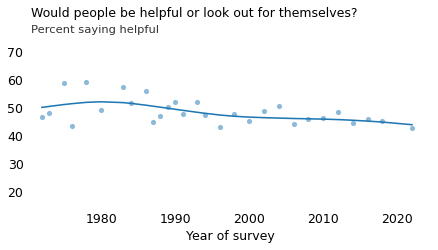

<IPython.core.display.Javascript object>

In [23]:
plot_by_year(gss, yvar, yval)
plt.savefig(f"optimism_{yvar}_by_year", dpi=300)

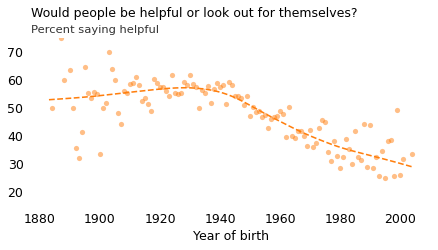

<IPython.core.display.Javascript object>

In [24]:
plot_by_cohort(gss, yvar, yval)
plt.savefig(f"optimism_{yvar}_by_cohort", dpi=300)

In [25]:
subset = gss.dropna(subset=["cohort"]).copy()
subset["cohort10"] = subset["cohort10"].astype(int)

table = make_table(subset, "year", yvar, "cohort10", yval)
del table[1890]
del table[1900]

<IPython.core.display.Javascript object>

In [26]:
def plot_group(table, group):
    entry = table[group]
    plot_series_smooth(
        entry["series"],
        entry["smooth"],
        plot_series=True,
        color="C2",
        label=f"Born in the {group}s",
    )
    plot_titles(title, subtitle)
    decorate(xlabel="Year of survey", ylim=ylim, xlim=xlim, loc="lower left")

<IPython.core.display.Javascript object>

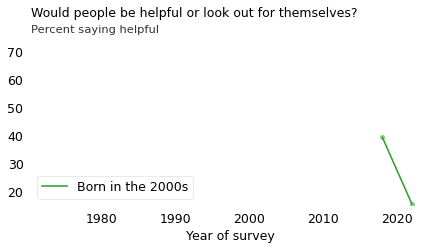

<IPython.core.display.Javascript object>

In [27]:
plot_group(table, 2000)
plt.savefig(f"optimism_{yvar}_one_cohort", dpi=300)

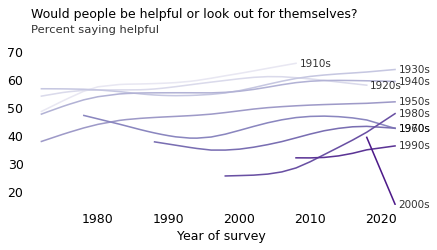

<IPython.core.display.Javascript object>

In [28]:
nudge = {"1960s": 0, "1970s": 0}
plot_table(table, nudge)
plt.savefig(f"optimism_{yvar}_by_cohort_over_year", dpi=300)

## trust

In [29]:
question = """Generally speaking, would you say that most people can be trusted 
or that you can't be too careful in dealing with people?
"""

title = "Can most people be trusted?"
subtitle = "Percent saying yes"
ylim = [5, 65]

<IPython.core.display.Javascript object>

In [30]:
# https://gssdataexplorer.norc.org/variables/441/vshow

# 1 = can trust
# 2 = can't be too careful
# 3 = depends

<IPython.core.display.Javascript object>

In [31]:
yvar = "trust"
yval = 1

series = gss[yvar]
series.value_counts()

trust
2.0    24890
1.0    15783
3.0     1966
Name: count, dtype: int64

<IPython.core.display.Javascript object>

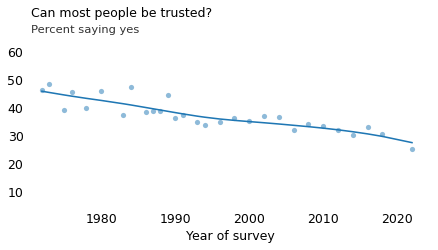

<IPython.core.display.Javascript object>

In [32]:
plot_by_year(gss, yvar, yval)
plt.savefig(f"optimism_{yvar}_by_year", dpi=300)

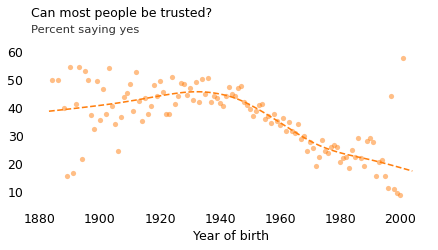

<IPython.core.display.Javascript object>

In [33]:
plot_by_cohort(gss, yvar, yval)
plt.savefig(f"optimism_{yvar}_by_cohort", dpi=300)

In [34]:
subset = gss.dropna(subset=["cohort"]).copy()
subset["cohort10"] = subset["cohort10"].astype(int)

table = make_table(subset, "year", yvar, "cohort10", yval)
del table[1890]
del table[1900]

<IPython.core.display.Javascript object>

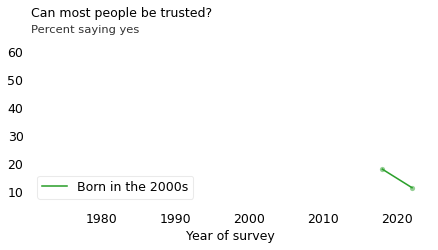

<IPython.core.display.Javascript object>

In [35]:
plot_group(table, 2000)
plt.savefig(f"optimism_{yvar}_one_cohort", dpi=300)

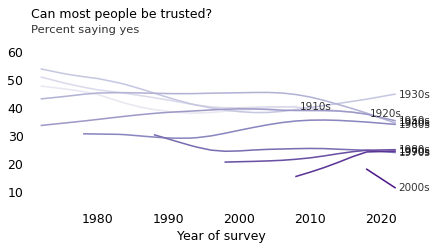

<IPython.core.display.Javascript object>

In [36]:
nudge = {"1960s": 0, "1970s": 0, "1980s": 0, "1990s": 0}
plot_table(table, nudge)
plt.savefig(f"optimism_{yvar}_by_cohort_over_year", dpi=300)

## fair

In [37]:
question = """Do you think most people would try to take advantage of 
you if they got a chance, or would they try to be fair?
"""

title = "Would people try to be fair?"
subtitle = "Percent saying yes"
ylim = [20, 79]

<IPython.core.display.Javascript object>

In [38]:
# https://gssdataexplorer.norc.org/variables/440/vshow

# 1 = would take advantage
# 2 = would try to be fair
# 3 = depends

<IPython.core.display.Javascript object>

In [39]:
yvar = "fair"
yval = 2

series = gss[yvar]
series.value_counts()

fair
2.0    23484
1.0    15979
3.0     2837
Name: count, dtype: int64

<IPython.core.display.Javascript object>

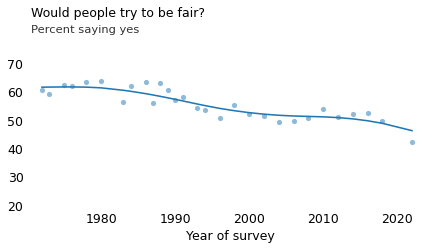

<IPython.core.display.Javascript object>

In [40]:
plot_by_year(gss, yvar, yval)
plt.savefig(f"optimism_{yvar}_by_year", dpi=300)

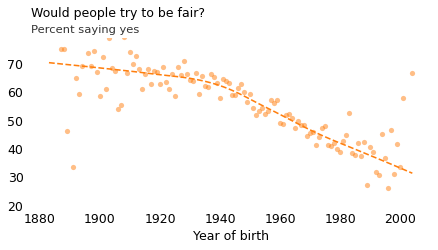

<IPython.core.display.Javascript object>

In [41]:
plot_by_cohort(gss, yvar, yval)
plt.savefig(f"optimism_{yvar}_by_cohort", dpi=300)

In [42]:
subset = gss.dropna(subset=["cohort"]).copy()
subset["cohort10"] = subset["cohort10"].astype(int)

table = make_table(subset, "year", yvar, "cohort10", yval)
del table[1890]
del table[1900]

<IPython.core.display.Javascript object>

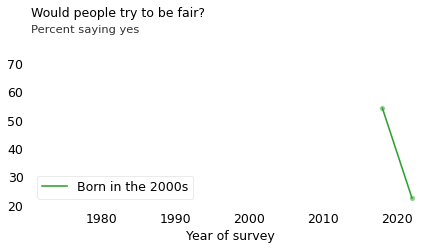

<IPython.core.display.Javascript object>

In [43]:
for group in table:
    plt.clf()
    plot_group(table, group)
    plt.savefig(f"optimism_{yvar}_{group}_by_year", dpi=300)

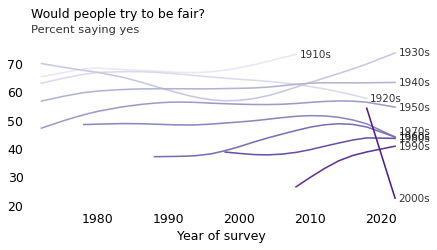

<IPython.core.display.Javascript object>

In [44]:
nudge = {"1960s": 0, "1970s": 1.8, "1980s": 0, "1990s": 0}
plot_table(table, nudge)
plt.savefig(f"optimism_{yvar}_by_cohort_over_year", dpi=300)

## happy

In [45]:
question = """Taken all together, how would you say things are these days--
would you say that you are very happy, pretty happy, or not too happy?
"""

title = "Are you happy?"
subtitle = "Percent saying very happy"
ylim = [10, 45]

<IPython.core.display.Javascript object>

In [46]:
# https://gssdataexplorer.norc.org/variables/452/vshow

# 1 = very happy
# 2 = pretty happy
# 3 = not too happy

<IPython.core.display.Javascript object>

In [47]:
yvar = "happy"
yval = 1

series = gss[yvar]
series.value_counts()

happy
2.0    37446
1.0    21550
3.0     8681
Name: count, dtype: int64

<IPython.core.display.Javascript object>

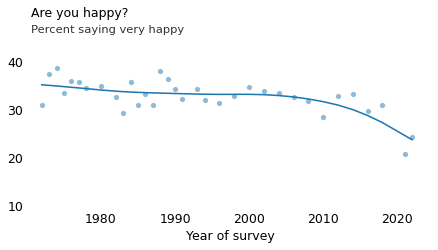

<IPython.core.display.Javascript object>

In [48]:
plot_by_year(gss, yvar, yval)
plt.savefig(f"optimism_{yvar}_by_year", dpi=300)

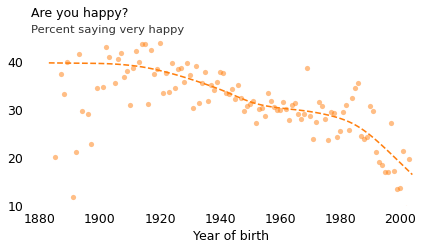

<IPython.core.display.Javascript object>

In [49]:
plot_by_cohort(gss, yvar, yval)
plt.savefig(f"optimism_{yvar}_by_cohort", dpi=300)

In [50]:
subset = gss.dropna(subset=["cohort"]).copy()
subset["cohort10"] = subset["cohort10"].astype(int)

table = make_table(subset, "year", yvar, "cohort10", yval)
del table[1890]
del table[1900]

<IPython.core.display.Javascript object>

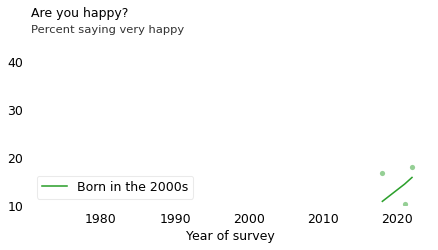

<IPython.core.display.Javascript object>

In [51]:
plot_group(table, 2000)
plt.savefig(f"optimism_{yvar}_one_cohort", dpi=300)

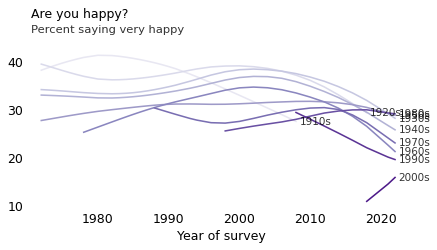

<IPython.core.display.Javascript object>

In [52]:
nudge = {"1950s": 0, "1960s": 0, "1970s": 0, "1980s": 0, "1990s": 0}
plot_table(table, nudge)
plt.savefig(f"optimism_{yvar}_by_cohort_over_year", dpi=300)

## explore...

In [53]:
question = """
"""

title = ""
subtitle = "Percent saying"
ylim = [5, 65]

<IPython.core.display.Javascript object>

In [54]:
# https://gssdataexplorer.norc.org/variables/437/vshow

# 1 =
# 2 =
# 3 =

<IPython.core.display.Javascript object>

In [55]:
yvar = "conclerg"
yval = 1

series = gss[yvar]
series.value_counts()

conclerg
2.0    24416
1.0    12476
3.0    10475
Name: count, dtype: int64

<IPython.core.display.Javascript object>

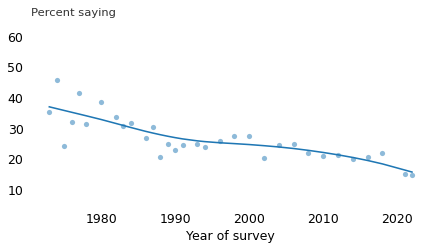

<IPython.core.display.Javascript object>

In [56]:
plot_by_year(gss, yvar, yval)
plt.savefig(f"optimism_{yvar}_by_year", dpi=300)

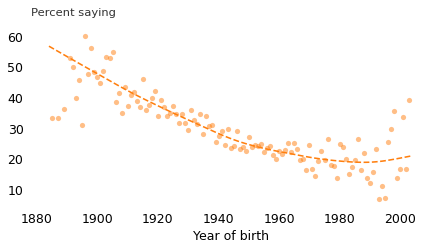

<IPython.core.display.Javascript object>

In [57]:
plot_by_cohort(gss, yvar, yval)
plt.savefig(f"optimism_{yvar}_by_cohort", dpi=300)

In [58]:
subset = gss.dropna(subset=["cohort"]).copy()
subset["cohort10"] = subset["cohort10"].astype(int)

table = make_table(subset, "year", yvar, "cohort10", yval)
del table[1890]
del table[1900]

<IPython.core.display.Javascript object>

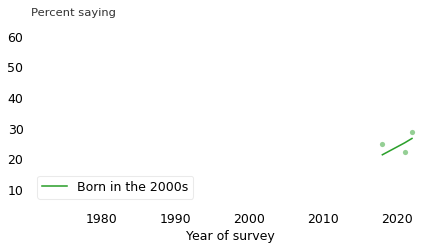

<IPython.core.display.Javascript object>

In [59]:
plot_group(table, 2000)
plt.savefig(f"optimism_{yvar}_one_cohort", dpi=300)

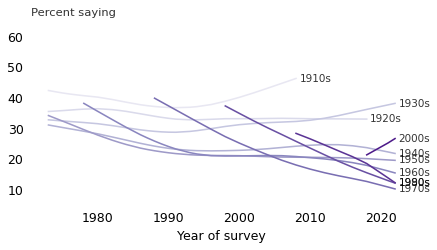

<IPython.core.display.Javascript object>

In [60]:
nudge = {"1950s": 0, "1960s": 0, "1970s": 0, "1980s": 0, "1990s": 0}
plot_table(table, nudge)
plt.savefig(f"optimism_{yvar}_by_cohort_over_year", dpi=300)

Copyright 2024 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).

In [61]:
yvar = "happy"
yval = 1

subset = gss.query("cohort10==2000").copy()
subset["y"] = (subset[yvar] == yval).astype(int)
subset["year1"] = subset["year"] - 1990
subset["year2"] = (subset["year"] - 1990) ** 2
subset[["year1", "year2", "y"]]

,year1,year2,y
62485,28,784,1
62506,28,784,0
62573,28,784,0
62585,28,784,0
62746,28,784,0
...,...,...,...
72354,32,1024,0
72360,32,1024,0
72365,32,1024,0
72378,32,1024,1


<IPython.core.display.Javascript object>

In [62]:
actual = subset.groupby("year")["y"].mean()
actual

year
2018    0.166667
2021    0.102439
2022    0.177632
Name: y, dtype: float64

<IPython.core.display.Javascript object>

In [63]:
import statsmodels.formula.api as smf

# Fit logistic regression model using smf
model = smf.logit("y ~ year1", data=subset)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.419664
         Iterations 6


<IPython.core.display.Javascript object>

In [64]:
year1 = actual.index - 1990
year2 = year1**2
df = pd.DataFrame(dict(year1=year1, year2=year2))
df

,year1,year2
0,28,784
1,31,961
2,32,1024


<IPython.core.display.Javascript object>

In [65]:
pred = result.predict(df)
pred.index = actual.index
pred

year
2018    0.108413
2021    0.143359
2022    0.156936
dtype: float64

<IPython.core.display.Javascript object>

<Axes: xlabel='year'>

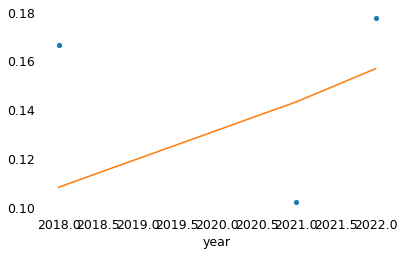

<IPython.core.display.Javascript object>

In [66]:
actual.plot(style="o")
pred.plot()